# 4.0 Use SVM to classify text

### Import neccesary packages

In [18]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC



### Define functions to measure performance

### Define piplines to explore different models approaches

In [18]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC



In [19]:

sgd = Pipeline([('vect', CountVectorizer()),
                ('model', SGDClassifier(loss='hinge', 
                                        penalty='l2',
                                        alpha=1e-3, 
                                        random_state=42, 
                                        max_iter=30, 
                                        tol=None))
               ])

sgd_ngrams = Pipeline([('vect', CountVectorizer(strip_accents='unicode', 
                                                stop_words='english',
                                                ngram_range=(1,3))
                       ),
                ('tfidf', TfidfTransformer()),
                ('model', SGDClassifier(class_weight='balanced',
                                        loss='hinge', 
                                        penalty='l2',
                                        random_state=42, 
                                        max_iter=30, 
                                        tol=None)),
               ])

sgd_ngrams_tfidf = Pipeline([('vect', CountVectorizer(strip_accents='unicode', 
                                                      stop_words='english',
                                                      ngram_range=(1,3))
                             ),
                ('tfidf', TfidfTransformer()),
                ('model', SGDClassifier(class_weight='balanced', 
                                        loss='hinge', 
                                        penalty='l2', 
                                        random_state=42, 
                                        max_iter=30, 
                                        tol=None)),
               ])

svm = Pipeline([('vect', CountVectorizer(strip_accents='unicode', 
                                         stop_words='english')
                ),
                ('model', LinearSVC(class_weight='balanced'))
               ])

svm_ngrams = Pipeline([('vect', CountVectorizer(strip_accents='unicode', 
                                                stop_words='english',
                                                ngram_range=(1,3))
                       ),
                ('model', LinearSVC(class_weight='balanced'))
                      ])

svm_ngrams_tfidf = Pipeline([('vect', CountVectorizer(strip_accents='unicode',
                                                      stop_words='english',
                                                      ngram_range=(1,3))
                             ),
                ('tfidf', TfidfTransformer()),
                ('model', LinearSVC(class_weight='balanced'))
                            ])

# 4. 3 Using SVM to predict CIRI scores

In [2]:
import pandas as pd

In [4]:
data_df = pd.read_csv('../data/Custom_State_Dep_Reports/CIRI_Text_1999_2015.csv')

In [20]:
data_df.columns = map(lambda x: str(x).upper(), data_df.columns)


In [14]:
state_dep = pd.read_csv('../data/us_state_dept_hr_reports_un_coded_1999_2018.csv')
state_dep.columns = map(lambda x: str(x).upper(), state_dep.columns)             

In [15]:
predict_df = state_dep[state_dep['YEAR'].between(2016,2018)]
predict_df = predict_df[['TEXT','YEAR','COUNTRY']]

In [ ]:
def get_data(CIRI_Label,start,end,remove_ents=True):  #function to extract train_test_split data from DB for given CIRI label
    
    global texts_done
    global total_texts
    
    texts_done  = 1
    total_texts = 0
    
    print("Extracting Data")  
    test_df = data_df[data_df['YEAR'].between(start,end)]
    test_df = test_df[['TEXT',CIRI_Label]].dropna()
    
    states = data_df[CIRI_Label].unique()
    to_drop = [ -77.0, -66.0,-999.]
    new_states = [x for x in states if x not in to_drop]
    test_df = test_df[test_df[CIRI_Label].isin(new_states)]
    
    if remove_ents:
        print("      Removing named entities from" + str(len(test_df['TEXT'])) + " Documents")
        test_df['TEXT'] = test_df['TEXT'].apply(lambda x: remove_location_ents(x))
    
    print("      Cleaning text")
    test_df['TEXT'] = test_df['TEXT'].apply(lambda x: clean_text(x))
    
    X_train, X_test, y_train, y_test = train_test_split(test_df['TEXT'], test_df[CIRI_Label], test_size=0.3, random_state = 42)
    return( X_train, X_test, y_train, y_test)

In [16]:
CIRI_Labels_Predict = ['PHYSINT', 'DISAP','KILL', 'POLPRIS', 'TORT', 'OLD_EMPINX', 'NEW_EMPINX', 'ASSN', 'FORMOV','DOMMOV', 'OLD_MOVE', 'SPEECH', 'ELECSD', 'OLD_RELFRE', 'NEW_RELFRE','WORKER', 'WECON', 'WOPOL', 'WOSOC', 'INJUD']

df_model_perform = pd.DataFrame(columns =['Class','y_test','y_pred'])
df_model_features = pd.DataFrame(columns =['Class','feature_names','feature_coefs'])
df_model_projections = pd.DataFrame(columns = ['Country','CIRI_LABEL','Prediction'])


selected_model = svm_tfidf



for C_label in CIRI_Labels_Predict[1:3]:
    
    print('Analysing: ' + str(C_label))
    

    df_code_perform  = pd.DataFrame(columns =['Class','y_test','y_pred'])
    df_code_features = pd.DataFrame(columns =['Class','feature_names','feature_coefs'])

    X_train, X_test, y_train, y_test= get_data(C_label,2000,2015, False)
    print('   Fitting model')
    x = selected_model.fit(X_train, y_train)
    y_pred = selected_model.predict(X_test)
    print('   Accuracy: %s' % accuracy_score(y_pred, y_test))
    
    # Extract key words and thier coefficients for later analysis
    df_code_features['Class'] = str(C_label)
    df_code_features['feature_names'] = pipe.named_steps['vect'].get_feature_names()
    df_code_features['feature_coefs'] =  pipe.named_steps['model'].coef_[0].ravel()
    
    # Extract model performance data
    df_code_perform['y_test'] =  y_test
    df_code_perform['y_pred'] = y_pred
    df_code_perform['Class'] = str(C_label)
    
    #record model performance and features for this CIRI label
    df_model_perform = df_model_perform.append(df_code_perform)
    df_model_features = df_model_features.append(df_code_perform)
    
    #Making predictions for 2016-2018:
    print('Classifying 2016-2018 texts')
    
    for index, row in predict_df.iterrows():
        predict_df['C_label'] = selected_model.predict(clean_text(row["TEXT"]))   #note there is no option to remove entities right now
    
    

NameError: name 'svm_tfidf' is not defined

In [1183]:
df_model_perform.to_csv('model_performance_report.csv')

[Text(0, 0, 'PHYSINT'),
 Text(0, 0, 'DISAP'),
 Text(0, 0, 'KILL'),
 Text(0, 0, 'POLPRIS'),
 Text(0, 0, 'TORT'),
 Text(0, 0, 'OLD_EMPINX'),
 Text(0, 0, 'NEW_EMPINX'),
 Text(0, 0, 'ASSN'),
 Text(0, 0, 'FORMOV'),
 Text(0, 0, 'DOMMOV'),
 Text(0, 0, 'OLD_MOVE'),
 Text(0, 0, 'SPEECH'),
 Text(0, 0, 'ELECSD'),
 Text(0, 0, 'OLD_RELFRE'),
 Text(0, 0, 'NEW_RELFRE'),
 Text(0, 0, 'WORKER'),
 Text(0, 0, 'WECON'),
 Text(0, 0, 'WOPOL'),
 Text(0, 0, 'WOSOC'),
 Text(0, 0, 'INJUD')]

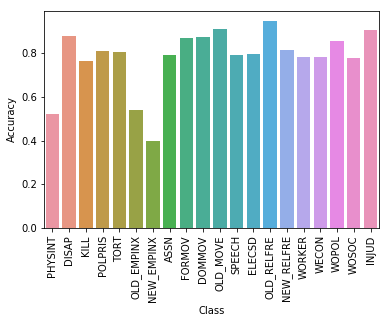

In [1240]:
from seaborn import barplot

performance = generate_performance_db(df_model_perform)

results = barplot(x=performance['Class'],y=performance['Accuracy'])
results.set_xticklabels(results.get_xticklabels(), rotation=90)

In [1146]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))




accuracy 0.7929824561403509
              precision    recall  f1-score   support

         0.0       0.82      0.75      0.78       127
         1.0       0.65      0.75      0.70       172
         2.0       0.89      0.84      0.86       271

   micro avg       0.79      0.79      0.79       570
   macro avg       0.79      0.78      0.78       570
weighted avg       0.80      0.79      0.80       570

[[ 95  31   1]
 [ 15 129  28]
 [  6  37 228]]


### Plot performance matrix for PHYSINT



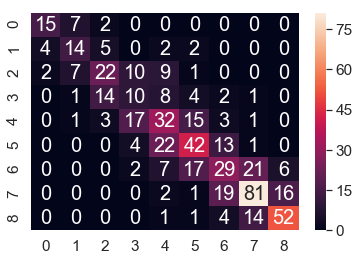

In [1252]:
import seaborn as sn
df= df_model_perform[df_model_perform['Class']=='PHYSINT']
array = confusion_matrix(df['y_test'],df['y_pred'])
df_cm = pd.DataFrame(array, range(9),
                  range(9))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 20})# font size





# Extracting feature importance from SGD

In [110]:

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_[0].ravel()  # I think you need to index for each class within the lable
    
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    #print('Top Positive Coefficients: ' + str(top_positive_coefficients))
    
    top_negative_coefficients = np.argsort(coef)[:top_features]
    #print('Top Negative Coefficients: ' + str(top_negative_coefficients))
    
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]] 
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    #print('Feature Names: ' + str(feature_names))
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    

def fit_model_report_features(pipe):
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    feature_names = pipe.named_steps['vect'].get_feature_names()
    model = pipe.named_steps['model']

    plot_coefficients(model, feature_names)
    print('   Accuracy: %s' % accuracy_score(y_pred, y_test))
    

## Using and example of free speech indicator

In [140]:
X_train, X_test, y_train, y_test= get_data('SPEECH',1999,2009, False)

   Extracting Data
      Cleaning text


#### Basic SVM

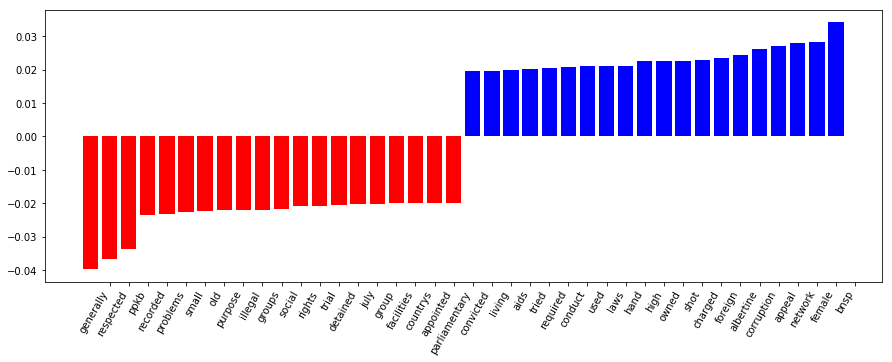

   Accuracy: 0.7585616438356164


In [141]:
fit_model_report_features(svm)

#### SVM with ngrams

In [ ]:
fit_model_report_features(svm_ngrams)

#### SVM with ngrams and tfidf

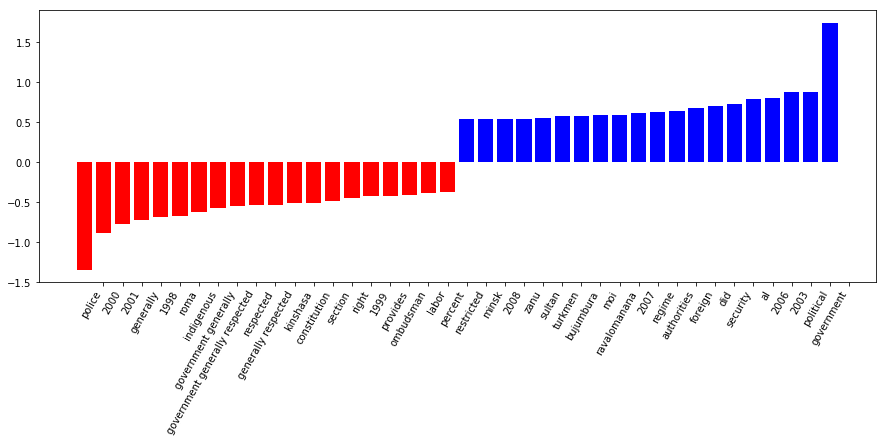

   Accuracy: 0.7964912280701755


In [119]:
fit_model_report_features(svm_ngrams_tfidf)

#### SGD no ngrams or tf idf

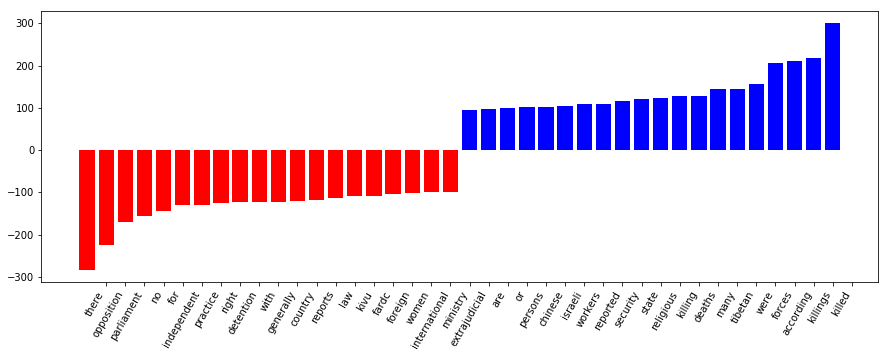

   Accuracy: 0.6526315789473685


In [124]:
fit_model_report_features(sgd)


### Try example 'KILL'

In [120]:
X_train, X_test, y_train, y_test= get_data('KILL',1999,2009, False)

   Extracting Data
      Cleaning text


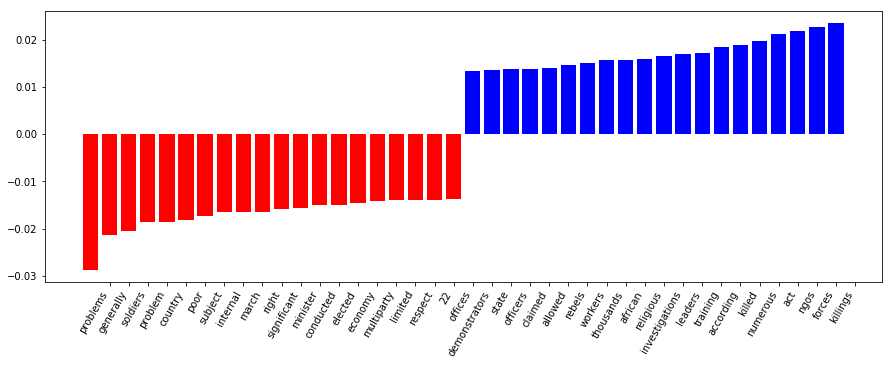

   Accuracy: 0.7596491228070176


In [125]:
fit_model_report_features(svm)

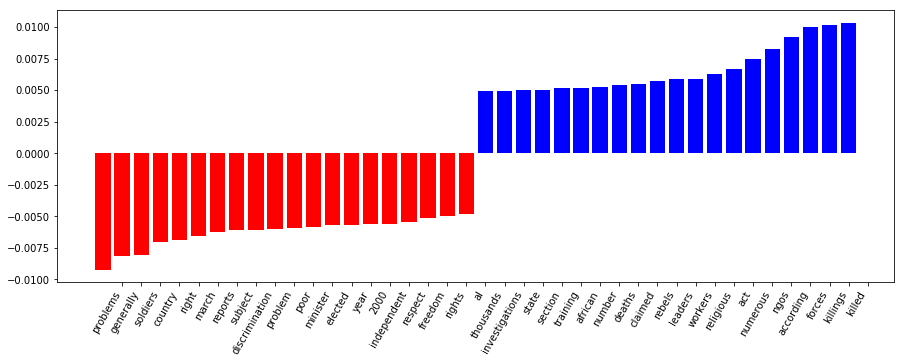

   Accuracy: 0.7614035087719299


In [126]:
fit_model_report_features(svm_ngrams)

looks like location based data is playing too much of a role in analysis